1. ## Recurrent Neural Networks using LSTM keras

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
# reading the data and calculating the computation time

%time training_data = pd.read_csv('../input/Google_Stock_Price_Train.csv')

# checking the shape of the data
training_data.shape

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 25.6 ms


(1258, 6)

In [3]:
training_data.head()


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


**Date:**  The date of recorded data

**Open:**  The price when stock market open

**High:**  The highest price price of date

**Low:**  The lowest price point of date

**Volume:**  Total Sale of stock on that date

In [4]:
# let's describe the data

training_data.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [5]:
# Lets work on the open stock price only and take out the " open " stock column.

training_data = training_data.iloc[:, 1:2]

# The training_data is in the form of dataframe.
training_data.shape

(1258, 1)

In [6]:
# checking the head of the data

training_data.head()

,Open
0,325.25
1,331.27
2,329.83
3,328.34
4,322.04


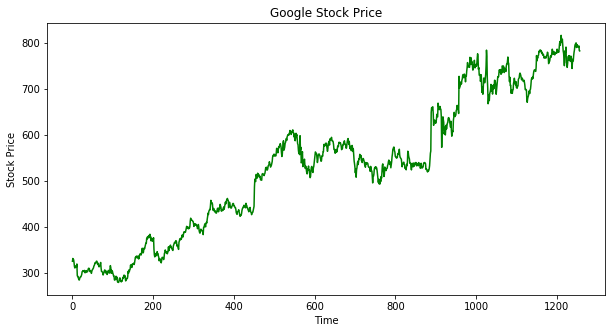

In [7]:
import matplotlib.pylab as plt
plt.figure(figsize=(10,5))
plt.plot(training_data, color ='green');
plt.ylabel('Stock Price')
plt.title('Google Stock Price')
plt.xlabel('Time')
plt.show()

In [8]:

# Normalize the training data between [0,1]
from sklearn.preprocessing import MinMaxScaler
#the fit method, when applied to the training dataset, learns the model parameters (for example, mean and standard deviation). 
#We then need to apply the transform method on the training dataset to get the transformed (scaled) training dataset.
#We could also perform both of this step in one step by applying fit_transform on the training dataset.
mm = MinMaxScaler(feature_range = (0, 1))
training_data_scaled = mm.fit_transform(training_data)
training_data_scaled.shape

(1258, 1)

As you can see that the Y-axis is completely changed, it is scaled in between 0 and 1, this is because, all the values are in different weights, so in order to have a good prediction, scaling has to be made. Remember that the scaling can be done on to floating point values.

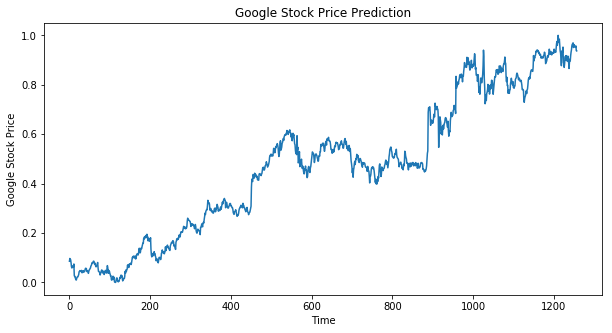

In [9]:
plt.figure(figsize=(10,5))
plt.plot(training_data_scaled);
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.show()

### Here comes the most important part of the model which is " Feature Scaling "

In [10]:

# Getting the inputs and outputs directly if you know how to consider the past data for the number of time stamps needed for RNN.
x_train = training_data_scaled[59:1257]
y_train = training_data_scaled[60:1258]
print(x_train.shape)
print(y_train.shape)

(1198, 1)
(1198, 1)


Remember that, the x_train and y_train must have the same values. to process RNN

An alternative approach using a for loop would be the code below.

In [11]:
'''for i in range(60,1258):
    #first 59 values of x will be the training data and the 60th value will be output
    #2nd set of values start from 60th (inculding the output of the  first set) will be the next 60 input values of the 2nd set and it continues.
    #append is to add the values to the values to x and y
    #as the values are in the form of dataframe, they has to be stored in the form of a numpy array.
    x_train.append(training_data_scaled[i-60:i, 0])
    y_train.append(training_data_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)
print(x_train.shape)
print(y_train.shape)'''

'for i in range(60,1258):\n    #first 59 values of x will be the training data and the 60th value will be output\n    #2nd set of values start from 60th (inculding the output of the  first set) will be the next 60 input values of the 2nd set and it continues.\n    #append is to add the values to the values to x and y\n    #as the values are in the form of dataframe, they has to be stored in the form of a numpy array.\n    x_train.append(training_data_scaled[i-60:i, 0])\n    y_train.append(training_data_scaled[i,0])\nx_train,y_train = np.array(x_train),np.array(y_train)\nprint(x_train.shape)\nprint(y_train.shape)'

**(Sample, time_steps, features)** represents the tensor you will feed into your LSTM, let’s look at these three “dimension” (we call that a rank for a tensor).

**Sample:** It’s the size of your minibatch: How many examples you give at once to your neural net.

**time_steps:** That’s the length of a sequence. Don’t forget, recurrent neural network are designed to process time-series.

**features:** That’s the dimension of each element of the time-series.

x_train should be a 3d array, hence reshaping the 2D to a 3D array. 

In [12]:
# reshaping
x_train = np.reshape(x_train, (1198,1,1))
print(x_train.shape)

(1198, 1, 1)


In [13]:
import keras 
from keras.models import Sequential #helps to create model, layer by layer.
from keras.layers import Dense, LSTM, Dropout
#The dense layer is fully connected layer, so all the neurons in a layer are connected to those in a next layer.
#The dropout drops connections of neurons from the dense layer to prevent overfitting. the neurons whose value falls under 0, will be removed.
#LSTM gates to control the memorizing process. For detailed information on LSTM, go through the link below.
''' https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47 '''

Using TensorFlow backend.


' https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47 '

In [14]:
# Create model using LSTM, Dropout and Dense layer as an output layer. 
#Initializing the RNN
regressor = Sequential()
regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# Adding second hidden layer
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))

In [16]:
# Adding third hidden layer
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))

In [17]:
#Adding fourth hidden layer
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [18]:
# Adding dense layer to get the final output. The input of n-1 layer, will be the output for n layer.
regressor.add(Dense(units = 1))

In [19]:
regressor.compile(optimizer = 'adam',loss = 'mean_squared_error')

ADAM optimization algorithm is used and a mean squared error loss function is optimized. This will be the same metric that we will use to evaluate the performance of the model to find the global minimum error.

In [ ]:
# Train the model
regressor.fit(x_train,y_train,epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


Let us take the test set and check the accuracy.

In [ ]:
test_data = pd.read_csv('../input/Google_Stock_Price_Test.csv')
test_stock = test_data.iloc[:,1:2]
len(test_stock)

In [ ]:
input_value = test_stock
input_value = mm.transform(input_value)
# perfor the same process, converting a 2D array to 3D
input_value = np.reshape(input_value, (20, 1, 1))

In [ ]:

prediction = regressor.predict(input_value)
prediction = mm.inverse_transform(prediction)

In [ ]:
# visualizing the results

plt.rcParams['figure.figsize'] = (15, 8)

plt.plot(test_stock, color = 'red', label = 'Real  Stock ')
plt.plot(prediction, color = 'green', label = 'Predicted  Stock ')
plt.title('Final Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()